<a href="https://colab.research.google.com/github/benetremmel/MachineLearning/blob/main/ML_GroupProject_Max_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os
import re
import spacy
import contractions
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
pip install pandas nltk
pip install contractions

##Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_merged = pd.read_pickle('/content/drive/My Drive/Group Work/Part 1/df_merged_cleaned.pkl')
df_ratings = pd.read_pickle('/content/drive/My Drive/Group Work/Part 1/df_ratings_cleaned.pkl')

# 1. Preprocessing

In [ ]:
df_merged.columns

Index(['movieId', 'belongs_to_collection', 'original_language', 'overview',
       'release_date', 'runtime', 'title', 'actors', 'keywords_extracted',
       'genre_extracted', 'production_company_extracted',
       'production_country_extracted'],
      dtype='object')

In [ ]:
df_merged.shape

(41107, 12)

In [ ]:
df_merged.head()

,movieId,belongs_to_collection,original_language,overview,release_date,runtime,title,actors,keywords_extracted,genre_extracted,production_company_extracted,production_country_extracted
0,1,1,en,"Led by Woody, Andy's toys live happily in his ...",1995-10-30,81.0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[jealousy, toy, boy, friendship, friends, riva...","[Animation, Comedy, Family]",[Pixar Animation Studios],[United States of America]
1,2,0,en,When siblings Judy and Peter discover an encha...,1995-12-15,104.0,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]","[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America]
2,3,1,en,A family wedding reignites the ancient feud be...,1995-12-22,101.0,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[fishing, best friend, duringcreditsstinger, o...","[Romance, Comedy]","[Warner Bros., Lancaster Gate]",[United States of America]
3,4,0,en,"Cheated on, mistreated and stepped on, the wom...",1995-12-22,127.0,Waiting to Exhale,"[Whitney Houston, Angela Bassett, Loretta Devi...","[based on novel, interracial relationship, sin...","[Comedy, Drama, Romance]",[Twentieth Century Fox Film Corporation],[United States of America]
4,5,1,en,Just when George Banks has recovered from his ...,1995-02-10,106.0,Father of the Bride Part II,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[baby, midlife crisis, confidence, aging, daug...",[Comedy],"[Sandollar Productions, Touchstone Pictures]",[United States of America]


In [ ]:
df_merged["overview"].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [ ]:
# Number of total values
total_entries = len(df_merged['overview'])
print(f"Total entries: {total_entries}")

# Number of missing values
missing_values = df_merged['overview'].isnull().sum()
print(f"Missing values: {missing_values}")

# Number of unique values
unique_values = df_merged['overview'].nunique()
print(f"Unique values: {unique_values}")

# Average length of movie descriptions
average_length = df_merged['overview'].dropna().apply(len).mean()
print(f"Average Length of Descriptions: {average_length:.2f} characters")

# Shortest length of movie descriptions
shortest_length = df_merged['overview'].dropna().apply(len).min()
print(f"Shortest Length of Descriptions: {shortest_length:.2f} characters")

# Longest length of movie descriptions
longest_length = df_merged['overview'].dropna().apply(len).max()
print(f"Longest Length of Descriptions: {longest_length:.2f} characters")

Total entries: 41107
Missing values: 0
Unique values: 40963
Average Length of Descriptions: 324.68 characters
Shortest Length of Descriptions: 1.00 characters
Longest Length of Descriptions: 1000.00 characters


After examining the entries in the df_merged DataFrame with 1000-character descriptions, I've decided to keep them. These descriptions are complete and informative, despite reaching the character limit. They are fully usable and add value to our analysis. Consequently, we will continue to include these long descriptions to ensure the dataset remains robust and comprehensive.

Identify entries where descriptions are extremely short. These might be errors or insufficient descriptions.

In [ ]:
short_descriptions_mask = df_merged['overview'].dropna().apply(len) < 30

# Filter the original DataFrame to show only rows with short descriptions
short_desc_df = df_merged[short_descriptions_mask]

# Display these descriptions to assess their relevance
short_desc_df.head(10)

,movieId,belongs_to_collection,original_language,overview,release_date,runtime,title,actors,keywords_extracted,genre_extracted,production_company_extracted,production_country_extracted
104,106,0,de,No overview found.,1994-11-07,104.0,Nobody Loves Me,"[Maria Schrader, Pierre Sanoussi-Bliss, Michae...","[prophecy, voodoo, single, falling in love, wo...","[Drama, Comedy, Family]",[],[Germany]
727,739,0,de,German Comedy,1996-04-11,92.0,Honeymoon,"[Veronica Ferres, Anica Dobra, Julia Stemberge...",[(none)],[Comedy],"[Roxy Film, MTM Cineteve, Pro 7]",[Germany]
805,824,0,de,No overview found.,1993-09-11,139.0,Kaspar Hauser,"[André Eisermann, Udo Samel, Jeremy Clyde, Kat...","[prisoner, bavaria, nuremberg, mensch als obje...","[Drama, Foreign]",[],"[Austria, Germany, Sweden]"
987,1001,0,en,No overview found.,1979-08-22,94.0,L'associé,"[Michel Serrault, Claudine Auger, Catherine Al...",[(none)],[Comedy],[],[]
1633,1692,0,en,No overview found.,1996-01-01,85.0,Alien Escape,"[Gail Harris, Bernie Van De Yacht, Heather For...","[female nudity, mutant, cabin, alien life-form...","[Horror, Science Fiction]",[],[United States of America]
2250,2343,0,en,No overview found.,1998-08-02,98.0,The Naked Man,"[Michael Rapaport, Michael Jeter, Rachael Leig...","[male nudity, double life, wrestling, murder, ...","[Comedy, Thriller]",[],[United States of America]
3313,3407,0,fr,No overview found.,1999-05-19,94.0,The Carriers Are Waiting,"[Benoît Poelvoorde, Morgane Simon, Bouli Lanne...",[(none)],"[Drama, Romance, Foreign]","[Eurimages, K2 SA, Canal+, Radio Télévision Be...","[France, Belgium, Switzerland]"
3788,3887,0,en,No overview found.,1998-01-01,94.0,Went to Coney Island on a Mission from God... ...,[],[independent film],[Drama],[],[]
4573,4667,0,en,,1989-03-18,124.0,Slaves of New York,"[Bernadette Peters, Chris Sarandon, Mary Beth ...",[(none)],[Drama],[],[United States of America]
7382,7566,1,en,No overview found.,1984-11-20,136.0,28 Up,[],[(none)],"[Documentary, Foreign]",[],[United Kingdom]


Identified entries: No overview found, blank, ..., Not Available, No Overview, x, no overview yet,

In [ ]:
# Create a list with unwanted movie descriptions
unwanted_strings = ['No overview found.', '', '...', 'Not Available', 'No Overview', 'x', 'no overview yet', "No overview"]

# Strip leading and trailing spaces and filter out rows with unwanted strings and ensure length is at least 10 characters
df_merged['overview'] = df_merged['overview'].str.strip()
df_merged = df_merged[~df_merged['overview'].isin(unwanted_strings) & (df_merged['overview'] != '') & (df_merged['overview'].str.len() >= 10)]

# Check the updated DataFrame
print("Total entries after cleaning:", df_merged.shape[0])

Total entries after cleaning: 40977


In [ ]:
# Find duplicates in the 'overview' column
duplicates = df_merged['overview'].duplicated(keep=False)

# Filter the DataFrame to show only the duplicated overviews
duplicated_overviews = df_merged[duplicates]

# Display the head of the duplicated overviews
print(duplicated_overviews[['overview', "release_date"]].head(10))

                                                overview release_date
2048   Wilbur the pig is scared of the end of the sea...   1973-03-01
2397   With friends like these, who needs enemies? Th...   1999-02-05
2741   Poor but happy, young Nello and his grandfathe...   1999-08-27
2985   Director Michael Apted revisits the same group...   1998-07-28
4705   Adventurer Allan Quartermain leads an expediti...   1937-01-01
7080   Nick Carraway, a young Midwesterner now living...   1974-03-27
8537   Adventurer Allan Quartermain leads an expediti...   1950-11-09
9024   Director Michael Apted revisits the same group...   1991-08-29
11539  Wilbur the pig is scared of the end of the sea...   2006-12-15
14547  Miser Ebenezer Scrooge is awakened on Christma...   2009-11-04


Duplicates are due to the fact that movies of the same series are featured in the dataset.

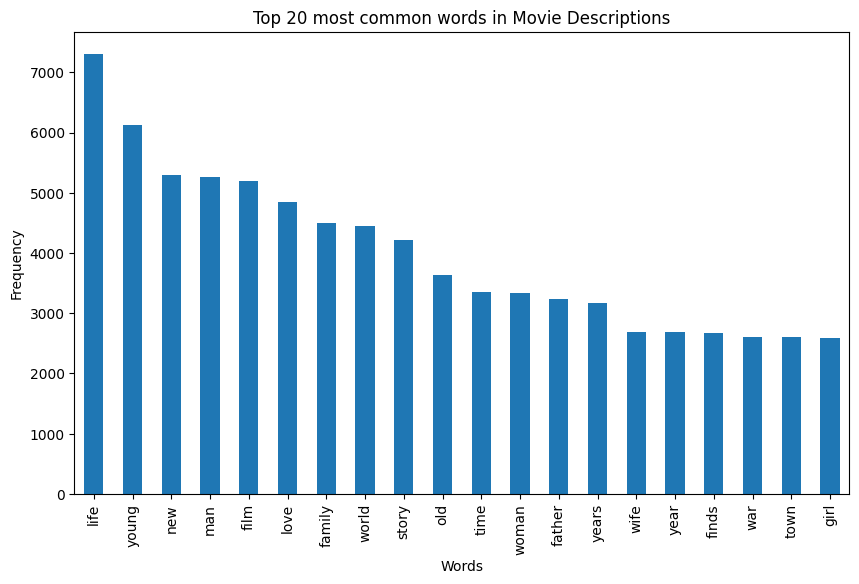

In [ ]:
# Create a vectorizer instance to count frequencies
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_merged['overview'].dropna())

# Convert X to a DataFrame
word_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
common_words = word_counts.sum().sort_values(ascending=False).head(20)

# Plotting
plt.figure(figsize=(10, 6))
common_words.plot(kind='bar')
plt.title('Top 20 most common words in Movie Descriptions')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

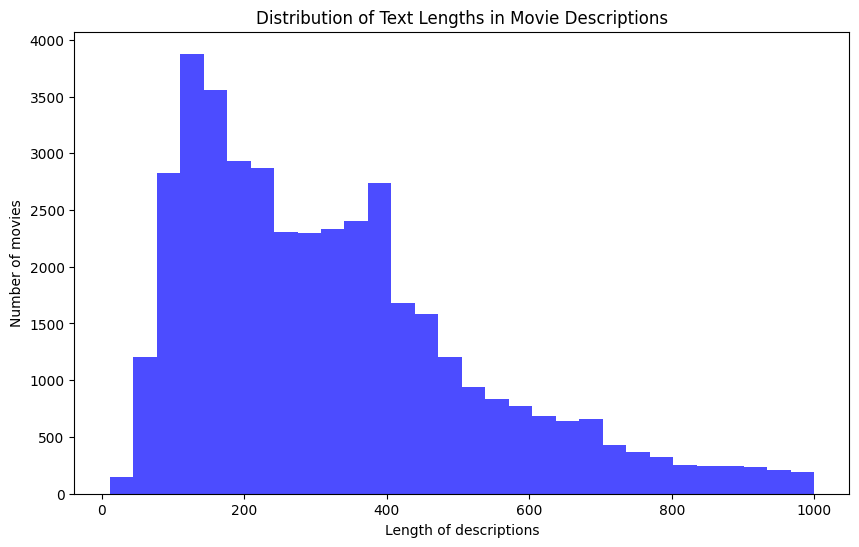

In [ ]:
# Calculate text lengths
text_lengths = df_merged['overview'].dropna().apply(len)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Text Lengths in Movie Descriptions')
plt.xlabel('Length of descriptions')
plt.ylabel('Number of movies')
plt.show()

Interpretation
- From the graph, it's evident that the distribution is right-skewed, with a majority of descriptions being between roughly 100 and 400 characters long. There are fewer very short descriptions (near 0 characters) and the number of descriptions decreases steadily as the length increases, with very few descriptions reaching up to 1000 characters.
- Peak Around 200-300 Characters: Most descriptions are concise, providing brief information about the movie, which is typical for summaries intended to give a quick overview without going into detail.
- Few Long Descriptions: The sharp decline in frequency as description length increases suggests that longer descriptions are uncommon. These might be detailed synopses rather than simple overviews.
- Very Short Descriptions: The relatively low number of extremely short descriptions (near 0 characters) is good as these might not provide useful information.

Considerations for NLP Recommender System based on Similarity Score

- The prevalence of shorter texts facilitates standardized embedding processes, reducing the complexity of handling variable text lengths. Descriptions within the 200-300 character range provide enough detail for effective similarity analysis, allowing accurate recommendations based on narrative elements.
- Vector Representation of Texts:
Texts need to be converted into numerical representations (e.g., TF-IDF, word embeddings) for similarity comparison. The effectiveness of these representations can vary with text length.
Short descriptions may not provide enough context for accurate similarity scoring, while very long descriptions might introduce too much noise or irrelevant information.
- Later, we will perform padding because standardizing text length can make computational processes more efficient and comparisons more uniform.
- We'll continuously refine our handling of text lengths based on system performance to balance detail richness with computational demands.

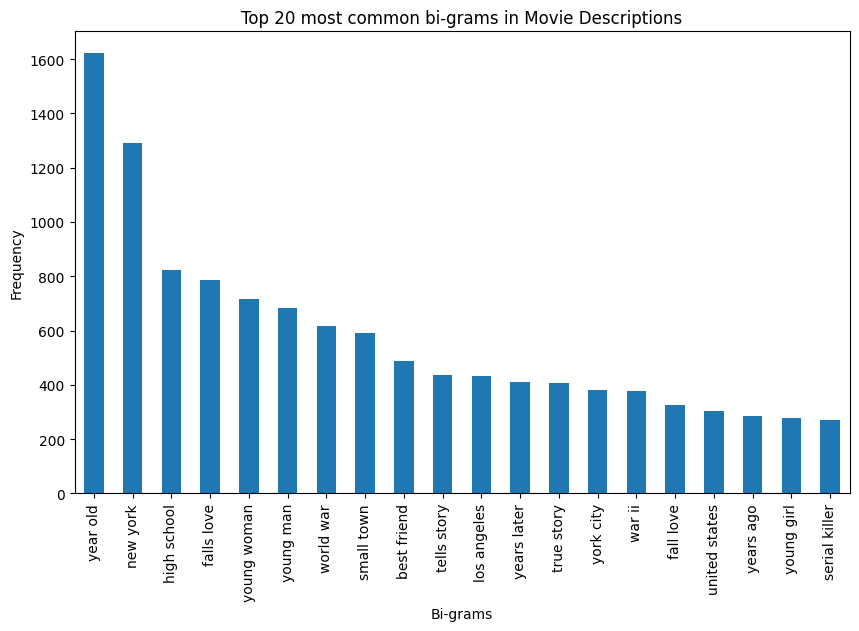

In [ ]:
# Bi-grams
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
bigram_matrix = bigram_vectorizer.fit_transform(df_merged['overview'].dropna())

# Sum up the counts of each bi-gram and sort
bigrams = pd.DataFrame(bigram_matrix.toarray(), columns=bigram_vectorizer.get_feature_names_out())
common_bigrams = bigrams.sum().sort_values(ascending=False).head(20)

# Plotting
plt.figure(figsize=(10, 6))
common_bigrams.plot(kind='bar')
plt.title('Top 20 most common bi-grams in Movie Descriptions')
plt.xlabel('Bi-grams')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Potentially checking for and removing noise like HTML tags, excessive symbols, etc.
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    return text

# Apply cleaning function
cleaned_overviews = df_merged['overview'].apply(clean_text)

In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40977 entries, 0 to 46755
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   movieId                       40977 non-null  Int64         
 1   belongs_to_collection         40977 non-null  int64         
 2   original_language             40977 non-null  object        
 3   overview                      40977 non-null  object        
 4   release_date                  40977 non-null  datetime64[ns]
 5   runtime                       40977 non-null  float64       
 6   title                         40977 non-null  object        
 7   actors                        40977 non-null  object        
 8   keywords_extracted            40977 non-null  object        
 9   genre_extracted               40977 non-null  object        
 10  production_company_extracted  40977 non-null  object        
 11  production_country_extracted  409

Download a set of English stopwords from the NLTK library, then define the clean_text function to standardize the movie descriptions by converting all text to lowercase, removing HTML tags, special characters, and filtering out stopwords. Finally apply this function to the 'overview' column of my df_merged DataFrame to prepare the data for further analysis.

In [ ]:
# Download the set of stopwords from NLTK
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def clean_text(text):
    if not pd.isna(text):
        # Convert text to lowercase
        text = text.lower()

        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)

        # Remove special characters
        text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

In [ ]:
# Apply the cleaning function to the 'overview' column
df_merged['overview'] = df_merged['overview'].apply(clean_text)

##Inspect the column

In [ ]:
pd.set_option('display.max_colwidth', None)
df_merged["overview"].head(10)

0                                                                                                                                         led woody andys toys live happily room andys birthday brings buzz lightyear onto scene afraid losing place andys heart woody plots buzz circumstances separate buzz woody owner duo eventually learns put aside differences
1                                                                                             siblings judy peter discover enchanted board game opens door magical world unwittingly invite alan adult whos trapped inside game years living room alans hope freedom finish game proves risky three find running giant rhinoceroses evil monkeys terrifying creatures
2                                                                                                                   family wedding reignites ancient feud nextdoor neighbors fishing buddies john max meanwhile sultry italian divorce opens restaurant local bait shop alarming locals worr

In [ ]:
# Inspect any row of the overview column
print(df_merged['overview'].iloc[[10, 50, 100]])

10                                                                                                                                                                                   widowed us president andrew shepherd one worlds powerful men anything wants covets sydney ellen wade washington lobbyist shepherds attempts courting spark wild rumors decimate approval ratings
51                                                                                       lenny wife amanda adopt baby lenny realizes son genius becomes obsessed finding boys biological mother hopes brilliant learns maxs mother linda ash kindhearted prostitute porn star lenny determined reform immoral lifestyle greek chorus chimes relate plot greek mythology quirky comedy
101    ray liotta stars medical examiner acquitted wifes murder many still question innocence obsessed finding wifes killer possible solution presents experimental serum designed neurobiology linda fiorentino ability transfer memories one person anothe

##Stemming/Lemmatization

Apply SpaCy to convert a word to its base form according to its part of speech and meaning (e.g., “better” to “good”). It is more sophisticated than stemming and uses lexical knowledge bases to derive the correct base forms.

In [ ]:
# Load the SpaCy English language model
nlp = spacy.load("en_core_web_sm")

# Lemmatization function using SpaCy
def lemmatize_text(text):
    if pd.isna(text):
        return text
    else:
        doc = nlp(text)
        lemmatized_tokens = [token.lemma_ for token in doc]
        return ' '.join(lemmatized_tokens)

# Apply lemmatization to the 'overview' column
df_merged['lemmatized_overview'] = df_merged['overview'].apply(lemmatize_text)

# Display the DataFrame with the lemmatized text
print(df_merged[['overview', 'lemmatized_overview']].head())

                                                                                                                                                                                                                                                                  overview  \
0                                              led woody andys toys live happily room andys birthday brings buzz lightyear onto scene afraid losing place andys heart woody plots buzz circumstances separate buzz woody owner duo eventually learns put aside differences   
1  siblings judy peter discover enchanted board game opens door magical world unwittingly invite alan adult whos trapped inside game years living room alans hope freedom finish game proves risky three find running giant rhinoceroses evil monkeys terrifying creatures   
2                        family wedding reignites ancient feud nextdoor neighbors fishing buddies john max meanwhile sultry italian divorce opens restaurant local bait shop alarming locals w

##Expanding Contractions

Words like “can’t,” “won’t,” and “you’re” should be expanded to “cannot,” “will not,” and “you are.” This helps in maintaining consistency in the text and can improve the performance of the model by reducing ambiguity.

In [ ]:
# Function to expand contractions using the contractions library
def expand_contractions_in_lemmatized(text):
    return contractions.fix(text)

# Apply expansion of contractions to the lemmatized 'overview' column
df_merged['expanded_lemmatized_overview'] = df_merged['lemmatized_overview'].apply(expand_contractions_in_lemmatized)

# Display the DataFrame with the original, lemmatized, and expanded lemmatized text
print(df_merged[['overview', 'lemmatized_overview', 'expanded_lemmatized_overview']].head())

                                                                                                                                                                                                                                                                  overview  \
0                                              led woody andys toys live happily room andys birthday brings buzz lightyear onto scene afraid losing place andys heart woody plots buzz circumstances separate buzz woody owner duo eventually learns put aside differences   
1  siblings judy peter discover enchanted board game opens door magical world unwittingly invite alan adult whos trapped inside game years living room alans hope freedom finish game proves risky three find running giant rhinoceroses evil monkeys terrifying creatures   
2                        family wedding reignites ancient feud nextdoor neighbors fishing buddies john max meanwhile sultry italian divorce opens restaurant local bait shop alarming locals w

In [ ]:
# Function to highlight differences across columns
def highlight_diffs(row):
    base = row.iloc[0]  # Taking the first column as the base for comparison
    colors = ['background-color: yellow' if str(v) != str(base) else '' for v in row]
    return colors

# Selecting columns for comparison
comparison_df = df_merged[['overview', 'lemmatized_overview', 'expanded_lemmatized_overview']]

# Applying the function to highlight differences
styled_comparison = comparison_df.head().style.apply(highlight_diffs, axis=1)
styled_comparison

,overview,lemmatized_overview,expanded_lemmatized_overview
0,led woody andys toys live happily room andys birthday brings buzz lightyear onto scene afraid losing place andys heart woody plots buzz circumstances separate buzz woody owner duo eventually learns put aside differences,lead woody andys toy live happily room andys birthday bring buzz lightyear onto scene afraid lose place andys heart woody plot buzz circumstance separate buzz woody owner duo eventually learn put aside difference,lead woody andys toy live happily room andys birthday bring buzz lightyear onto scene afraid lose place andys heart woody plot buzz circumstance separate buzz woody owner duo eventually learn put aside difference
1,siblings judy peter discover enchanted board game opens door magical world unwittingly invite alan adult whos trapped inside game years living room alans hope freedom finish game proves risky three find running giant rhinoceroses evil monkeys terrifying creatures,sibling judy peter discover enchant board game open door magical world unwittingly invite alan adult who s trap inside game year living room alan hope freedom finish game prove risky three find run giant rhinocerose evil monkey terrify creature,sibling judy peter discover enchant board game open door magical world unwittingly invite alan adult who trap inside game year living room alan hope freedom finish game prove risky three find run giant rhinocerose evil monkey terrify creature
2,family wedding reignites ancient feud nextdoor neighbors fishing buddies john max meanwhile sultry italian divorce opens restaurant local bait shop alarming locals worry shell scare fish away shes less interested seafood cooking hot time max,family wedding reignite ancient feud nextdoor neighbor fishing buddy john max meanwhile sultry italian divorce open restaurant local bait shop alarming local worry shell scare fish away she s less interested seafood cook hot time max,family wedding reignite ancient feud nextdoor neighbor fishing buddy john max meanwhile sultry italian divorce open restaurant local bait shop alarming local worry she will scare fish away she less interested seafood cook hot time max
3,cheated mistreated stepped women holding breath waiting elusive good man break string lessthanstellar lovers friends confidants vannah bernie glo robin talk determined find better way breathe,cheat mistreat step woman hold breath wait elusive good man break string lessthanstellar lover friend confidant vannah bernie glo robin talk determined find well way breathe,cheat mistreat step woman hold breath wait elusive good man break string lessthanstellar lover friend confidant vannah bernie glo robin talk determined find well way breathe
4,george banks recovered daughters wedding receives news shes pregnant georges wife nina expecting planning selling home thats plan like george change arrival grandchild kid,george bank recover daughter wedding receive news she s pregnant georges wife nina expect planning sell home that s plan like george change arrival grandchild kid,george bank recover daughter wedding receive news she pregnant georges wife nina expect planning sell home that plan like george change arrival grandchild kid



We can observe an issue where certain contractions such as "she's" and "that's" have been reduced to single letters ("s") after the lemmatization and contraction expansion processes. This often occurs due to how contraction expansion and lemmatization handle possessive forms and contracted forms, where the lemmatizer might not correctly interpret these forms if they are processed in certain sequences.

In [ ]:
# Function to clean text by removing unwanted characters or patterns
def clean_text(text):
    # Regex to remove isolated single letters (except 'a' and 'I' which can be valid words)
    cleaned_text = re.sub(r'\b(?<!\')[a-hj-z]\b', '', text)
    # Removing extra spaces that may be created after removing characters
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

# Apply cleaning function to the 'expanded_lemmatized_overview' column
df_merged['expanded_lemmatized_overview'] = df_merged['expanded_lemmatized_overview'].apply(clean_text)

##Removing Repeated Characters and Numbers

Often in informal texts (like tweets or comments), you might find repeated characters for emphasis (e.g., “sooo good”) or numbers. Reducing character repetition to two or three can standardize words while retaining their emphasized form, making them easier to analyze.

In [ ]:
# Function to clean text by removing unwanted characters, reducing repeated characters, and removing numbers
def clean_text(text):
    # Regex to remove isolated single letters (except 'a' and 'I' which can be valid words)
    text = re.sub(r'\b(?<!\')[a-hj-z]\b', '', text)
    # Reduce repeated characters (more than three times) to two repetitions
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    # Remove numbers
    text = re.sub(r'\b\d+\b', '', text)
    # Removing extra spaces that may be created after removing characters and numbers
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning function directly to the 'expanded_lemmatized_overview' column
df_merged['expanded_lemmatized_overview'] = df_merged['expanded_lemmatized_overview'].apply(clean_text)

##Pruning

Removing less informative parts of a sentence, such as certain adverbs, interjections, or conjunctions, can help focus the model on the more substantive parts of the text.

In [ ]:
# Function to prune less informative parts of a sentence
def syntax_based_pruning(text):
    doc = nlp(text)
    # List of POS tags to remove, e.g., 'RB' for adverbs, 'UH' for interjections, 'CC' for conjunctions
    tags_to_remove = {'RB', 'UH', 'CC'}
    # Rebuild the sentence without the less informative words
    pruned_text = ' '.join([token.text for token in doc if token.pos_ not in tags_to_remove])
    return pruned_text

# Apply syntax-based pruning to the 'expanded_lemmatized_overview' column
df_merged['expanded_lemmatized_overview'] = df_merged['expanded_lemmatized_overview'].apply(syntax_based_pruning)

                                                                                                                                                                                                                         expanded_lemmatized_overview
0                                lead woody andys toy live happily room andys birthday bring buzz lightyear onto scene afraid lose place andys heart woody plot buzz circumstance separate buzz woody owner duo eventually learn put aside difference
1  sibling judy peter discover enchant board game open door magical world unwittingly invite alan adult who trap inside game year living room alan hope freedom finish game prove risky three find run giant rhinocerose evil monkey terrify creature
2          family wedding reignite ancient feud nextdoor neighbor fishing buddy john max meanwhile sultry italian divorce open restaurant local bait shop alarming local worry she will scare fish away she less interested seafood cook hot time max
3               

##Tokenization

Convert text data into tokens. Keras offers utilities like Tokenizer which can convert text to sequences that are more manageable for neural networks. The Tokenizer class allows to vectorize a text corpus by turning each text into a sequence of integers. Num_words=10000 limits the tokenizer to the top 10,000 words (the most frequent words in the data). The oov_token="" is used for out-of-vocabulary words during text-to-sequence conversion.

In [ ]:
# Initialize the Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_merged['expanded_lemmatized_overview'].dropna())

# Each word gets a unique integer value
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

Found 74343 unique tokens.


- num_words: Restricts the tokenizer to the top num_words frequent words, controlling sequence size and vocabulary. Despite this limit, word_index includes all unique words. By setting num_words=10000, the tokenizer focuses on the top 10,000 frequent words, reducing model complexity and memory usage.
- oov_token: Acts as a placeholder for words not in the top num_words or unseen during fitting. It ensures out-of-vocabulary words are represented as "<OOV>", aiding in handling new texts and maintaining sequence integrity. With oov_token="<OOV>", words outside the active vocabulary are replaced, facilitating management of new words.

##Sequencing

Converting the tokenized text into sequences of integers based on the vocabulary generated during tokenization. Each word in the text is replaced with its corresponding integer value. This step creates input data that can be fed into a machine learning model for training or prediction.

In [ ]:
# Convert all of the cleaned text to a list of sequences
sequences = tokenizer.texts_to_sequences(df_merged['expanded_lemmatized_overview'].dropna())

# Example of how these sequences look
print("Example of sequences:", sequences[:2])

Example of sequences: [[55, 4733, 7636, 1636, 21, 1800, 482, 7636, 1070, 85, 5603, 1, 1436, 383, 2517, 89, 119, 7636, 265, 4733, 263, 5603, 1147, 757, 5603, 4733, 283, 1863, 376, 125, 168, 3259, 1520], [1919, 4078, 579, 46, 3932, 1034, 189, 381, 797, 1003, 18, 2017, 719, 1663, 701, 387, 455, 475, 189, 15, 781, 482, 1663, 170, 754, 1287, 189, 351, 4653, 64, 3, 86, 863, 1, 181, 2904, 1104, 521]]


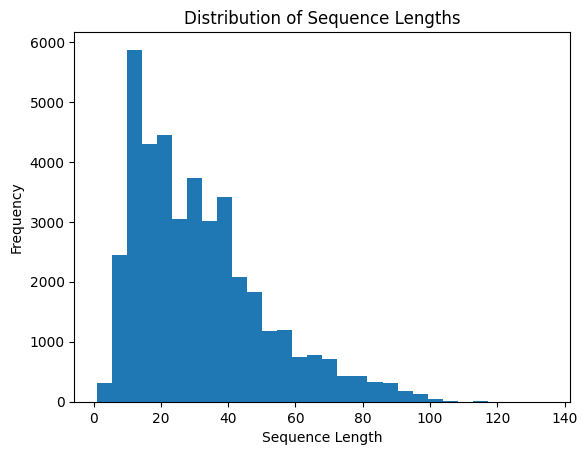

95th Percentile of Sequence Lengths: 71.0


In [ ]:
# Compute sequence lengths
sequence_lengths = [len(seq) for seq in sequences]

# Plot histogram of sequence lengths
import matplotlib.pyplot as plt
plt.hist(sequence_lengths, bins=30)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

# Compute the maximum sequence length (e.g., 95th percentile)
percentile_95 = np.percentile(sequence_lengths, 95)
print("95th Percentile of Sequence Lengths:", percentile_95)

In [ ]:
# Compute sequence lengths
sequence_lengths = [len(seq.split()) for seq in df_merged['expanded_lemmatized_overview']]

# Find the maximum sequence length
max_sequence_length = max(sequence_lengths)

print("Maximum Sequence Length:", max_sequence_length)

Maximum Sequence Length: 135


##Padding

Neural networks require inputs to be the same size. Padding the sequences ensures that all inputs are of standard length.

In [ ]:
# Pad sequences to ensure uniform input size
max_length = max(len(x) for x in sequences)  # You can set a predefined max_length if you know your data well
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Show how padded sequences look
print("Example of padded sequences:", padded_sequences[:2])

Example of padded sequences: [[  55 4733 7636 1636   21 1800  482 7636 1070   85 5603    1 1436  383
  2517   89  119 7636  265 4733  263 5603 1147  757 5603 4733  283 1863
   376  125  168 3259 1520    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [1919 4078  579   46 3932 1034  189  381  797 1003   18 2017  719 1663
   701  387  455  475  189   15  781  482 1663  170  754 1287  189  351
  4653   64    3   86  863    1  181 2904 1104  521    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0   

##Split data

Split your data into training and testing sets or create an embedding matrix if using pre-trained embeddings like GloVe or Word2Vec.

In [ ]:
#from sklearn.model_selection import train_test_split

# Split the data
#X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df_merged['target_variable'], test_size=0.2, random_state=42)

#2. Feature Extraction

In Keras, transforming text tokens into embeddings can significantly enhance the performance of models by providing a dense, lower-dimensional representation of the text data that captures semantic meanings of words.

Since we have relatively large number of unique tokens (74343) compared to the size of your dataset (40977 entries). In such cases, it's common to use pre-trained word embeddings due to the high dimensionality of the word vectors and the potential for overfitting when training embeddings from scratch with limited data.

####GloVe Embeddings

Downloading GloVe embeddings from the website, there are a couple of options available. The choice of which GloVe embeddings to download and use depends on the specifics of your task, the nature of your dataset, and the computational resources available to you.

- For General Applications: The Wikipedia + Gigaword embeddings (glove.6B.zip) are usually sufficient for most tasks and are a good starting point due to their reasonable size and coverage.
- For Web Text or Diverse Language Use: The Common Crawl (42B tokens) embeddings provide a wider vocabulary and capture a broad snapshot of language used across the internet.
- For Social Media Text: If your data includes tweets or text from other social media platforms, the Twitter embeddings can be particularly useful.
- For Case-Sensitive Tasks: If it's crucial to retain information about the capitalization of words, such as in named entity recognition, the Common Crawl (840B tokens, cased) version would be beneficial.

I choosed the Wikipedia 2014+ Gigaword 5 GloVe. The Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 300d vectors) dataset is a solid all-around set of embeddings for many types of NLP tasks.

In [ ]:
# Load GloVe embeddings
embeddings_index = {}
path_to_glove_file = '/content/drive/My Drive/Group Work/Part 2/glove.6B/glove.6B.300d.txt'

with open(path_to_glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

print(f'Loaded {len(embeddings_index)} word vectors.')

Loaded 400001 word vectors.


In [ ]:
# Create Embedding matrix
vocab_size = 10000  # Assuming you're using the top 10,000 tokens
embedding_dim = 300  # Using 300-dimensional GloVe vectors

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
# Define Keras model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

max_length = 200  # Define this based on your dataset

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length,
              weights=[embedding_matrix], trainable=False),
    Flatten(),  # This layer flattens the embedded input for the dense layer
    Dense(10, activation='relu'),  # Example hidden layer
    Dense(1, activation='sigmoid')  # Output layer; change based on your needs
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 300)          3000000   
                                                                 
 flatten (Flatten)           (None, 60000)             0         
                                                                 
 dense (Dense)               (None, 10)                600010    
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3600021 (13.73 MB)
Trainable params: 600021 (2.29 MB)
Non-trainable params: 3000000 (11.44 MB)
_________________________________________________________________


**Model Architecture Overview**

**Embedding Layer (embedding_1)**:
Purpose: Transforms word indices (input tokens) into dense vectors of fixed size (embeddings).
Output Shape: (None, 200, 300) means that for each batch (batch size unspecified, hence None), the layer outputs a matrix of shape 200x300. Here, 200 is the sequence length of the input text (number of words per text), and 300 is the dimensionality of each word vector.
Parameters: 3,000,000 parameters, indicating the layer uses a vocabulary of 10,000 words (from input_dim=10000) each represented as a 300-dimensional vector (output_dim=300). These parameters are fixed during training (Non-trainable params), meaning the GloVe vectors loaded are not updated through backpropagation.


**Flatten Layer (flatten_1)**
Purpose: Flattens the input from the embedding layer to create a single long feature vector. This transformation is necessary to pass the data to densely connected layers.
Output Shape: (None, 60000) where 60000 comes from multiplying the sequence length (200) by the dimensionality of the embeddings (300), indicating each input sample is transformed into a vector of 60000 features.
Parameters: 0, as flattening does not involve learnable parameters, it merely reshapes the data.

**Dense Layer (dense_2):**

Purpose: Fully connected layer that aims to learn the non-linear combinations of the high-dimensional input features.
Output Shape: (None, 10) suggests that this layer outputs 10 features for each input sample.
Parameters: 600,010, calculated as 60000 (input features) * 10 (output features) + 10 (bias terms).


**Dense Layer (dense_3)**:
Purpose: Another fully connected layer, commonly used as the output layer for binary classification problems (using sigmoid activation function).
Output Shape: (None, 1) implies that the layer produces a single scalar output per input sample, which can be interpreted as the probability of the input sample belonging to one class.
Parameters: 11, calculated as 10 (input features from previous dense layer) * 1 (output feature) + 1 (bias term).

**Summary of Parameters**

Total Parameters: 3,600,021
This count includes all parameters in the model—both trainable and non-trainable.
Trainable Parameters: 600,021
These are the parameters the model will update during training. They reside in the dense layers where the model learns to map the dense representations to outputs.
Non-Trainable Parameters: 3,000,000
These parameters come from the embedding layer, which uses fixed pre-trained GloVe vectors. These are not updated during training, which helps in leveraging prior knowledge encapsulated in these embeddings while focusing the learning process on higher-order feature combinations in the dense layers.

**Interpretation and Use**

This model configuration is effective for tasks where the input is text data that needs to be classified into two categories (binary classification). The use of pre-trained embeddings allows the model to immediately leverage a rich, pre-initialized representation of language, which can often lead to better performance compared to training embeddings from scratch—especially when the available training data is not very large.

#3. Model - Convolutional Neural Networks (CNN)

In [ ]:
# Split your dataset into training, validation, and test sets
X_train, X_temp = train_test_split(sequences, test_size=0.2, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense

# Define the size of the vocabulary (num_words) and maximum sequence length (max_sequence_length)
num_words = embedding_matrix.shape[0]  # Use the number of rows in the embedding matrix
max_sequence_length = 135  # Replace 'your_max_sequence_length' with the actual maximum sequence length

# Define CNN model architecture
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=64, activation='relu'))
cnn_model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
print(cnn_model.summary())

# Train the model
history = cnn_model.fit(X_train, epochs=10, batch_size=32, validation_data=(X_val, None))  # No labels provided for validation

# Evaluate the model
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 135, 300)          3000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 131, 128)          192128    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 65, 128)           0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 8320)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                532544    
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                      

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (32781,) + inhomogeneous part.